# How to: Find EMIT Data using NASA's CMR API and Download

**Summary**  

This notebook will explain how to access Earth Surface Minteral Dust Source Investigation (EMIT) data programmaticly using NASA's CMR API. The Common Metadata Repository (CMR) is a metadata system that catalogs Earth Science data and associated metadata records. The CMR Application Programming Interface (API) provides programatic search capabilities through CMR's vast metadata holdings using various parameters and keywords. When querying NASA's CMR, there is a limit of 1 million granules matched and only 2000 granules returned per page. 

**Requirements:**
+ A NASA [Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to download EMIT data   
+ Selected the `emit_tutorials` environment as the kernel for this notebook.
  + For instructions on setting up the environment, follow the the `setup_instructions.md` included in the `/setup/` folder of the repository.  

**Learning Objectives**  
- How to find EMIT data using NASA's CMR API
- How to download programmaticly 

---

Import the required packages

In [1]:
# Install required packages if needed:
# %pip install geopandas cartopy

import requests
import pandas as pd
import datetime as dt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon, box
import cartopy.crs as ccrs
import cartopy.feature as cfeature


---

## Obtaining the Concept ID

NASA EarthData's unique ID for this dataset (called Concept ID) is needed for searching the dataset. The dataset Digital Object Identifier or DOI can be used to obtain the Concept ID. DOIs can be found by clicking the `Citation` link on the LP DAAC's [EMIT Product Pages](https://lpdaac.usgs.gov/product_search/?query=emit&view=cards&sort=title).

In [2]:
doi = '10.5067/EMIT/EMITL1BRAD.001'# EMIT L1B TOA Radiance

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi
concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']
print(concept_id)

C2408009906-LPCLOUD


This is the unique NASA-given concept ID for the EMIT L2A Reflectance dataset, which can be used to retrieve relevant files (or granules).

---

## Searching using CMR API

When searching the CMR API, users can provide spatial bounds and date-time ranges to narrow their search. These spatial bounds can be either, points, a bounding box, or a polygon. 

Specify start time and dates and reformat them to the structure necessary for searching CMR.

In [3]:
# Temporal Bound - Year, month, day. Hour, minutes, and seconds (ZULU) can also be included 
# Let's start by stepping through each day to see if there was EMIT data recorded.

# start_date = dt.datetime(2023, 1, 1, 0, 0, 0)
# end_date = dt.datetime(2025, 12, 25, 23, 59, 59)  

start_date = dt.datetime(2024, 1, 1, 0, 0, 0)
end_date = dt.datetime(2024, 2, 16, 23, 59, 59)  

# start_date = dt.datetime(2023, 11, 13, 0, 0, 0)
# end_date = dt.datetime(2023, 11, 15, 23, 59, 59)  
# end_date = dt.datetime(2023, 9, 30, 23, 59, 59) 

# Calculate total number of days
total_days = (end_date - start_date).days + 1

# Let's create a list of temporal strings that each span 1 day
# num_days = [*range(start_date.day,end_date.day+1,1)]              # range(start_value, end_value (not included), step

# CMR formatted start and end times
dt_format = '%Y-%m-%dT%H:%M:%SZ'

# Create temporal strings for each day
temporal_str = []
# temporal_str = [None]*len(num_days)         # define an empty list


for day_offset in range(total_days):
    current_day = start_date + dt.timedelta(days=day_offset)
    start_day = dt.datetime(current_day.year, current_day.month, current_day.day, 0, 0, 0)
    end_day = dt.datetime(current_day.year, current_day.month, current_day.day, 23, 59, 59)
    temporal_str.append(start_day.strftime(dt_format) + ',' + end_day.strftime(dt_format))
    
print(f"Total days: {len(temporal_str)}")
print(f"First: {temporal_str[0]}")
print(f"Last: {temporal_str[-1]}")


# for idx, val in enumerate(num_days):
#     start_day = dt.datetime(start_date.year, start_date.month, val)
#     end_day = dt.datetime(start_date.year, start_date.month, val, 23, 59, 59)
#     temporal_str[idx] = start_day.strftime(dt_format) + ',' + end_day.strftime(dt_format)
    
# print(temporal_str)

Total days: 47
First: 2024-01-01T00:00:00Z,2024-01-01T23:59:59Z
Last: 2024-02-16T00:00:00Z,2024-02-16T23:59:59Z


The CMR API only allows 2000 results to be shown at a time. Using `page_num` allows a user to loop through the search result pages. The sections below walk through using Points, Bounding Boxes, and Polygons to spatially constrain a search made using the CMR API. 

### Search using Points

To search using a point we specify a latitude and longitude.

In [4]:
# This cell will perform the search for EMIT data meeting the defined constraints for space, time and cloud cover

import time  # used for retry backoff

# Search Using a Bounding Box
# first 2 points = bottom left corner of box: (long, lat)
# second 2 points = top right corner of box: (long, lat)

# bound = (-83.25161, -39.38781, -69.9396, -16.39129) 
bound = (-93.43101, -44.98539, -69.74249, -16.80625)
bound_str = ','.join(map(str,bound))

# page_num = 1
page_size = 2000 # CMR page size limit

# CLOUD COVER CONSTRAINT
min_cloud_cover = 0  # Minimum cloud cover percentage (0-100)

granule_arr = []

# retry configuration for transient CMR errors
MAX_RETRIES = 5
BASE_DELAY = 5  # seconds

for idx, val in enumerate(temporal_str):
    
    page_num = 1
    # define the day to search
    day2search = temporal_str[idx]

    while True:
    
        # defining parameters
        cmr_param = {
            "collection_concept_id": concept_id, 
            "page_size": page_size,
            "page_num": page_num,
            "temporal": day2search,      # <-- TIME CONSTRAINT HERE
            "bounding_box[]": bound_str, # <-- SPATIAL CONSTRAINT HERE
        }

        granulesearch = cmrurl + 'granules.json'

        # perform request with retries and handle non-JSON responses gracefully
        granules = []
        for attempt in range(1, MAX_RETRIES + 1):
            try:
                response = requests.post(granulesearch, data=cmr_param, timeout=60)
            except requests.exceptions.RequestException as e:
                print(f"Request exception on attempt {attempt} for {day2search}, page {page_num}: {e}")
                if attempt < MAX_RETRIES:
                    sleep_time = BASE_DELAY * attempt
                    print(f"  Retrying in {sleep_time}s...")
                    time.sleep(sleep_time)
                    continue
                else:
                    print("  Max retries reached — skipping this page/day.")
                    response = None
                    break

            if response is None:
                break

            if response.status_code == 200:
                try:
                    # Check if response has content before parsing
                    if not response.text or response.text.strip() == '':
                        print(f"Empty response body from CMR (attempt {attempt}) for {day2search}, page {page_num}.")
                        if attempt < MAX_RETRIES:
                            time.sleep(BASE_DELAY * attempt)
                            continue
                        else:
                            print("  Max retries reached due to empty response — skipping.")
                            granules = []
                            break
                    
                    js = response.json()
                except ValueError as e:
                    # invalid JSON (e.g., empty body), retry for transient server issues
                    print(f"Invalid JSON from CMR (attempt {attempt}) for {day2search}, page {page_num}: {str(e)}")
                    if attempt < MAX_RETRIES:
                        time.sleep(BASE_DELAY * attempt)
                        continue
                    else:
                        print("  Max retries reached due to invalid JSON — skipping.")
                        js = {}
                # Safely extract 'entry' list
                granules = js.get('feed', {}).get('entry', []) if js else []
                break
            elif response.status_code in (502, 503, 504):
                # transient server errors: retry
                print(f"CMR returned {response.status_code} (attempt {attempt}) for {day2search}, page {page_num}. Retrying...")
                if attempt < MAX_RETRIES:
                    time.sleep(BASE_DELAY * attempt)
                    continue
                else:
                    print("  Max retries reached for server error — skipping this page/day.")
                    granules = []
                    break
            else:
                # unexpected HTTP status; log response text (truncated) and stop retrying
                print(f"CMR returned HTTP {response.status_code} for {day2search}, page {page_num}. Response (truncated): {response.text[:200]}")
                granules = []
                break

        # If request ultimately failed and returned no granules, exit loop for this page/day
        if not granules:
            # If this was the first page and no granules because of server issues, break to next day
            # Otherwise, break paging loop
            break

        # process granules if present
        if granules:
            print(f"Found {len(granules)} EMIT granule(s) on {day2search} (page {page_num}):")
            for g in granules:
                granule_urls = ''
                granule_poly = ''

                # read cloud cover
                # This is a percentage from 0 to 100
                cloud_cover = g.get('cloud_cover')
                granule_title = g.get('title', 'Unknown')
                
                # CLOUD COVER FILTER: Skip this granule if cloud cover is below threshold
                if cloud_cover is None:
                    print(f"  ⚠ {granule_title}: No cloud_cover metadata found (FILTERED OUT)")
                    continue
                try:
                    cloud_cover_int = int(cloud_cover)
                    if cloud_cover_int < min_cloud_cover:
                        print(f"  ✗ {granule_title}: {cloud_cover_int}% cloud cover < {min_cloud_cover}% (FILTERED OUT)")
                        continue
                    else:
                        print(f"  ✓ {granule_title}: {cloud_cover_int}% cloud cover >= {min_cloud_cover}% (KEEPING)")
                except (ValueError, TypeError):
                    # skip if cloud_cover isn't an integer-like value
                    print(f"  ⚠ {granule_title}: Invalid cloud_cover value: {cloud_cover} (FILTERED OUT)")
                    continue
                
                # read in EMIT start time of measurement recording
                time_start = g.get('time_start')
                if not time_start:
                    continue
                # convert time string to a datetime object
                try:
                    time_start = dt.datetime.strptime(time_start[0:-5] + 'Z', dt_format)
                except Exception:
                    # skip if time parsing fails
                    continue

                # reading bounding geometries
                if 'polygons' in g:
                    polygons= g['polygons']
                    multipolygons = []
                    for poly in polygons:
                        i = iter(poly[0].split(" "))
                        ltln = list(map(" ".join, zip(i, i)))
                        multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                    granule_poly = MultiPolygon(multipolygons)
            
                # Get https URLs to .nc files and exclude .dmrpp files, .nc.1 files, and other metadata
                granule_urls = [x['href'] for x in g.get('links', []) 
                              if 'https' in x.get('href', '') 
                              and '.nc' in x.get('href', '') 
                              and '.dmrpp' not in x.get('href', '')
                              and '.nc.1' not in x.get('href', '')
                              and not x.get('href', '').endswith('.nc.1')]
                # Add to list
                granule_arr.append([granule_urls, cloud_cover, time_start, granule_poly])

            page_num += 1
        else: 
            break

print(f"\nTotal EMIT granules with >= {min_cloud_cover}% cloud cover: {len(granule_arr)}")

# ============================================================================
# FILTER EMIT GRANULES BY OCEAN COVERAGE
# ============================================================================
# Remove EMIT granules that are entirely over land
# Keep only granules that have at least some pixels over ocean

print("\n" + "="*70)
print("FILTERING EMIT GRANULES BY OCEAN COVERAGE")
print("="*70)

# Load Natural Earth land data to check ocean coverage
# Using geodatasets package (modern replacement for deprecated geopandas.datasets)
try:
    import geodatasets
    # Read land polygons from geodatasets
    land_gdf = gpd.read_file(geodatasets.get_path('naturalearth.land'))
except ImportError:
    # Fallback: Download directly from Natural Earth server
    print("  Installing geodatasets via URL fallback...")
    land_url = "https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip"
    land_gdf = gpd.read_file(land_url)

# Merge all land polygons into a single geometry for efficient intersection checks
land_union = land_gdf.geometry.union_all()

# Filter granule_arr to keep only granules with ocean coverage
granule_arr_filtered = []

for idx, granule_info in enumerate(granule_arr):
    granule_urls, cloud_cover, time_start, granule_poly = granule_info
    
    # Check if granule is valid
    if not granule_poly or not granule_poly.is_valid:
        print(f"  ⚠ Granule {idx}: Invalid polygon, skipping")
        continue
    
    # Check if granule intersects with land
    land_intersection = granule_poly.intersection(land_union)
    granule_area = granule_poly.area
    intersection_area = land_intersection.area if land_intersection else 0
    
    # If intersection area is less than granule area, then granule has some ocean
    # (or if there's no intersection at all, it's entirely over ocean)
    ocean_fraction = (granule_area - intersection_area) / granule_area if granule_area > 0 else 0
    
    if ocean_fraction > 0.05:  # Keep if at least 1% of granule is over ocean
        granule_arr_filtered.append(granule_info)
        print(f"  ✓ Granule {idx} @ {time_start}: {ocean_fraction*100:.1f}% ocean coverage - KEEP")
    else:
        print(f"  ✗ Granule {idx} @ {time_start}: {ocean_fraction*100:.1f}% ocean coverage - REMOVE (land-only)")

granule_arr = granule_arr_filtered  # Replace with filtered list

print(f"\nFiltered results: {len(granule_arr)} EMIT granules with ocean coverage")
print("="*70 + "\n")

Found 4 EMIT granule(s) on 2024-01-01T00:00:00Z,2024-01-01T23:59:59Z (page 1):
  ✓ EMIT_L1B_RAD_001_20240101T162847_2400111_001: 5% cloud cover >= 0% (KEEPING)
  ✓ EMIT_L1B_RAD_001_20240101T162859_2400111_002: 13% cloud cover >= 0% (KEEPING)
  ✓ EMIT_L1B_RAD_001_20240101T162910_2400111_003: 22% cloud cover >= 0% (KEEPING)
  ✓ EMIT_L1B_RAD_001_20240101T162922_2400111_004: 9% cloud cover >= 0% (KEEPING)
Found 5 EMIT granule(s) on 2024-01-04T00:00:00Z,2024-01-04T23:59:59Z (page 1):
  ✓ EMIT_L1B_RAD_001_20240104T154026_2400410_002: 81% cloud cover >= 0% (KEEPING)
  ✓ EMIT_L1B_RAD_001_20240104T154038_2400410_003: 70% cloud cover >= 0% (KEEPING)
  ✓ EMIT_L1B_RAD_001_20240104T154106_2400410_004: 6% cloud cover >= 0% (KEEPING)
  ✓ EMIT_L1B_RAD_001_20240104T154118_2400410_005: 5% cloud cover >= 0% (KEEPING)
  ✓ EMIT_L1B_RAD_001_20240104T154130_2400410_006: 0% cloud cover >= 0% (KEEPING)
Found 3 EMIT granule(s) on 2024-01-05T00:00:00Z,2024-01-05T23:59:59Z (page 1):
  ✓ EMIT_L1B_RAD_001_20240105T

In [5]:
## Now with the granules found above, we want to see if there is a coincident measurement with the Terra instrument within some alloted time window

# This Terra data is recorded every 5 minutes, every day. So to check, we need to determine if any of the individual footprints overlap with EMIT. Therefore we need to know if the metadata is within our time window

# # EMIT-Terra
# We want to over overlapping measurements between EMIT and Terra
# The Terra data products we want are the MODIS dervied cloud products (MOD06_L2, doi:10.5067/MODIS/MOD06_L2.061),
# the MODIS dervied total precipitable water products (MOD05_L2, doi:10.5067/MODIS/MOD05_L2.061),
# the MODIS derived cloud mask products (MOD35_L2, doi:10.5067/MODIS/MOD35_L2.061)
# the Terra geolocation products (MOD03, doi: 10.5067/MODIS/MOD03.061)


doi_terra_modis_cloud = '10.5067/MODIS/MOD06_L2.061' # DOI for Terra MODIS Cloud Products

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi_terra_modis_cloud
concept_id_terra_modis_cloud = requests.get(doisearch).json()['feed']['entry'][0]['id']
print(concept_id_terra_modis_cloud)

C1443535037-LAADS


In [6]:
# Now we will search for Terra data
# We will search over the polygon defined from the granule found above
# We will search within a time window defined by the granules above


page_size = 2000 # CMR page size limit


# Define the time window
time_window = 10                 # minutes

granule_arr_terra = []
coincident_pairs = []  # NEW: Track which EMIT-Terra pairs have spatial overlap

for idx, val in enumerate(granule_arr):
    
    page_num = 1
    # define the day to search
    start_time_2search = granule_arr[idx][2] - dt.timedelta(minutes=(time_window/2))
    end_time_2search = granule_arr[idx][2] + dt.timedelta(minutes=(time_window/2))
    time2search = dt.datetime.strftime(start_time_2search, dt_format) + ',' + dt.datetime.strftime(end_time_2search, dt_format)
    # Define a geo-json file using the polygon shapefile using the EMIT footprint
    # This is the area that will be searched
    geojson = {"shapefile": ("test.geojson", gpd.GeoSeries([granule_arr[idx][-1]]).to_json(), "application/geo+json")}
    
    # NEW: Get the EMIT polygon for this granule
    emit_poly = granule_arr[idx][-1]
    emit_granule_urls = granule_arr[idx][0]
    emit_time_start = granule_arr[idx][2]
    
    terra_matches_for_this_emit = []  # NEW: Track Terra granules that spatially overlap with this EMIT granule
    while True:
    
        # defining parameters
        cmr_param = {
        "collection_concept_id": concept_id_terra_modis_cloud, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": time2search,
        "simplify-shapefile": 'true' # this is needed to bypass 5000 coordinates limit of CMR
        }

        granulesearch = cmrurl + 'granules.json'
        response = requests.post(granulesearch, data=cmr_param, files=geojson)
        granules = response.json()['feed']['entry']
        
        # ADD THIS DIAGNOSTIC PRINT
        if granules:
            print(f"EMIT granule {idx}: Found {len(granules)} Terra granules on page {page_num}")
            print(f"  EMIT time: {emit_time_start}")
            print(f"  Search time window: {time2search}")
            print(f"  First Terra granule title: {granules[0]['title']}")
       
        if granules:
            for g in granules:
                granule_urls = ''
                granule_poly = ''

                # read cloud cover
                # This is a percentage from 0 to 100
                #cloud_cover = g['cloud_cover']

                # reading bounding geometries
                if 'polygons' in g:
                    polygons= g['polygons']
                    multipolygons = []
                    for poly in polygons:
                        i=iter(poly[0].split (" "))
                        ltln = list(map(" ".join,zip(i,i)))
                        multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                    granule_poly = MultiPolygon(multipolygons)
            
                # Get https URLs to data files, excluding metadata, backup, and preview files
                granule_urls = [x['href'] for x in g['links'] 
                              if 'https' in x['href'] 
                              and ('.nc' in x['href'] or '.hdf' in x['href'])
                              and not x['href'].endswith(('.nc.1', '.hdf.1', '.hdf.html', '.hdf.html.1', '.hdf.jpg', '.hdf.jpg.1'))
                              and '.dmrpp' not in x['href']]
                
                # NEW: EXPLICIT SPATIAL OVERLAP CHECK
                # Check if the Terra granule polygon actually intersects with the EMIT polygon
                if granule_poly and granule_poly.is_valid and emit_poly.is_valid:
                    if granule_poly.intersects(emit_poly):
                        # Calculate intersection area
                        intersection = granule_poly.intersection(emit_poly)
                        intersection_area = intersection.area
                        
                        print(f"    ✓ Terra granule '{g['title']}' OVERLAPS with EMIT granule {idx}")
                        print(f"      Intersection area: {intersection_area:.6f} sq degrees")
                        
                        # Add to list with EMIT metadata for tracking
                        granule_arr_terra.append({'granule_urls': granule_urls, 'granule_poly': granule_poly, 'emit_idx': idx, 'emit_poly': emit_poly, 'emit_time': emit_time_start})
                        terra_matches_for_this_emit.append(g['title'])
                        coincident_pairs.append({
                            'emit_idx': idx,
                            'emit_time': emit_time_start,
                            'emit_urls': emit_granule_urls,
                            'terra_title': g['title'],
                            'terra_urls': granule_urls,
                            'terra_poly': granule_poly,
                            'intersection_area': intersection_area
                        })
                    else:
                        # This shouldn't happen if CMR is working correctly, but let's log it
                        print(f"    ✗ CMR returned Terra granule '{g['title']}' but NO spatial overlap detected!")
                else:
                    if not granule_poly:
                        print(f"    ⚠ Terra granule '{g['title']}' has no polygon data")
                    elif not granule_poly.is_valid:
                        print(f"    ⚠ Terra granule '{g['title']}' has invalid polygon")
                    elif not emit_poly.is_valid:
                        print(f"    ⚠ EMIT polygon {idx} is invalid")

            page_num += 1
        else: 
            print(f"EMIT granule {idx}: No Terra granules found\n")
            break
    
    if terra_matches_for_this_emit:
        print(f"EMIT granule {idx}: Matched with {len(terra_matches_for_this_emit)} Terra granules: {terra_matches_for_this_emit}\n")
    else:
        print(f"EMIT granule {idx}: No spatially overlapping Terra granules found\n")

print(f"\n{'='*70}")
print(f"SUMMARY: Found {len(coincident_pairs)} spatially coincident EMIT-Terra pairs")
print(f"{'='*70}")
print(f"\nFull list of coincident pairs:")
for pair in coincident_pairs:
    print(f"  EMIT {pair['emit_idx']} @ {pair['emit_time']} <-> Terra {pair['terra_title']} (overlap: {pair['intersection_area']:.6f} sq deg)")

EMIT granule 0: No Terra granules found

EMIT granule 0: No spatially overlapping Terra granules found

EMIT granule 1: No Terra granules found

EMIT granule 1: No spatially overlapping Terra granules found

EMIT granule 2: No Terra granules found

EMIT granule 2: No spatially overlapping Terra granules found

EMIT granule 3: No Terra granules found

EMIT granule 3: No spatially overlapping Terra granules found

EMIT granule 4: No Terra granules found

EMIT granule 4: No spatially overlapping Terra granules found

EMIT granule 5: No Terra granules found

EMIT granule 5: No spatially overlapping Terra granules found

EMIT granule 6: No Terra granules found

EMIT granule 6: No spatially overlapping Terra granules found

EMIT granule 7: No Terra granules found

EMIT granule 7: No spatially overlapping Terra granules found

EMIT granule 8: No Terra granules found

EMIT granule 8: No spatially overlapping Terra granules found

EMIT granule 9: No Terra granules found

EMIT granule 9: No spat

In [7]:
print(coincident_pairs)

[{'emit_idx': 55, 'emit_time': datetime.datetime(2024, 1, 27, 15, 3, 32), 'emit_urls': ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20240127T150332_2402709_011/EMIT_L1B_RAD_001_20240127T150332_2402709_011.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20240127T150332_2402709_011/EMIT_L1B_OBS_001_20240127T150332_2402709_011.nc'], 'terra_title': 'LAADS:7960778514', 'terra_urls': ['https://data.laadsdaac.earthdatacloud.nasa.gov/prod-lads/MOD06_L2/MOD06_L2.A2024027.1500.061.2024030185104.hdf'], 'terra_poly': <MULTIPOLYGON (((-91.8 -20.5, -69.6 -23.8, -66.5 -5.64, -87.1 -2.66, -91.8 -...>, 'intersection_area': 0.6162806062725261}, {'emit_idx': 56, 'emit_time': datetime.datetime(2024, 1, 27, 15, 3, 44), 'emit_urls': ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20240127T150344_2402709_012/EMIT_L1B_RAD_001_20240127T150344_2402709_012.nc', 'h

---

## Download Selected Coincident Pairs

After visually inspecting the coincident pairs, select which ones you want to download by their index in the `coincident_pairs` list. This will retrieve:
- EMIT L1B Radiance (EMITL1BRAD)
- Terra/MODIS Cloud Products (MYD06_L2)
- Terra/MODIS Total Precipitable Water (MYD05_L2)
- Terra/MODIS Cloud Mask (MYD35_L2)
- Terra/MODIS Geolocation (MYD03)


In [10]:
import os
import getpass
import subprocess

# ============================================================================
# USER CONFIGURATION
# ============================================================================

# Get current username and set download directory
username = getpass.getuser()
download_dir = f"/Users/{username}/Downloads/coincident_data_terra"

print(f"Current user: {username}")
print(f"Download base directory: {download_dir}\n")

# SELECT WHICH PAIRS TO DOWNLOAD (by index in coincident_pairs list)
# Example: pairs_to_download = [0, 2, 5] for specific pairs
#          pairs_to_download = list(range(len(coincident_pairs))) for all pairs
pairs_to_download = [0]  # Download first pair only

print(f"Downloading {len(pairs_to_download)} pair(s)...\n")

# ============================================================================
# RETRIEVE CONCEPT IDs FOR ALL PRODUCTS
# ============================================================================

print("Retrieving Concept IDs for all products...")

product_dois = {
    'EMIT_L1B': '10.5067/EMIT/EMITL1BRAD.001',
    # MYD06_L2 is already in terra_urls, so we DON'T search for it again
    'MOD06_L2': '10.5067/MODIS/MOD06_L2.061',  # Keep for visualization
    'MOD021KM': '10.5067/MODIS/MOD021KM.061',
    'MOD05_L2': '10.5067/MODIS/MOD05_L2.061',
    'MOD35_L2': '10.5067/MODIS/MOD35_L2.061',
    'MOD03': '10.5067/MODIS/MOD03.061',
}

concept_ids = {}
for product_key, doi in product_dois.items():
    try:
        doisearch = cmrurl + 'collections.json?doi=' + doi
        response = requests.get(doisearch)
        concept_ids[product_key] = response.json()['feed']['entry'][0]['id']
        print(f"  ✓ {product_key}: {concept_ids[product_key]}")
    except:
        print(f"  ✗ {product_key}: Failed to retrieve concept ID")


# ============================================================================
# ORGANIZE URLs BY PAIR AND FOLDER
# ============================================================================

pair_url_mapping = {}  # Maps pair_idx to list of URLs and their target folder

for pair_idx in pairs_to_download:
    if pair_idx >= len(coincident_pairs):
        print(f"⚠ Warning: Pair index {pair_idx} out of range (only {len(coincident_pairs)} pairs available)")
        continue
    
    pair = coincident_pairs[pair_idx]
    print(f"Processing pair {pair_idx}:")
    print(f"  EMIT {pair['emit_idx']} @ {pair['emit_time']}")
    print(f"  Terra {pair['terra_title']}")
    print(f"  Intersection area: {pair['intersection_area']:.6f} sq degrees")
    
    # Create folder name from datetime
    emit_time = pair['emit_time']
    time_str_folder = emit_time.strftime('%H%M%S')  # UTC time in HHMMSS format
    folder_name = f"{emit_time.year}_{emit_time.month}_{emit_time.day}_T{time_str_folder}"
    pair_folder = os.path.join(download_dir, folder_name)
    os.makedirs(pair_folder, exist_ok=True)
    
    print(f"  Pair folder: {folder_name}/")
    
    # ========================================================================
    # CRITICAL FIX: Use a set to track unique URLs and avoid duplicates
    # ========================================================================
    pair_urls_set = set()  # Use a set to automatically handle duplicates
    
    # Collect EMIT data files (.nc files only, no images yet)
    if pair['emit_urls']:
        emit_data_urls = [url for url in pair['emit_urls'] if url.endswith('.nc')]
        print(f"    - EMIT L1B data URLs: {len(emit_data_urls)} file(s)")
        pair_urls_set.update(emit_data_urls)
    
    # Search for EMIT quicklook PNG images from CMR metadata
    print("    - Searching for EMIT quicklook PNGs...")
    emit_idx = pair['emit_idx']
    
    try:
        page_num = 1
        best_match = None
        min_time_diff = float('inf')
        
        while True:
            emit_search_param = {
                "collection_concept_id": concept_id,
                "page_size": 2000,
                "page_num": page_num,
            }
            
            response = requests.post(cmrurl + 'granules.json', data=emit_search_param)
            emit_granules = response.json()['feed']['entry']
            
            if emit_granules:
                for g in emit_granules:
                    granule_time_str = g.get('time_start')
                    if granule_time_str:
                        try:
                            granule_time = dt.datetime.strptime(granule_time_str[0:-5] + 'Z', dt_format)
                            time_diff = abs((granule_time - pair['emit_time']).total_seconds())
                            
                            if time_diff < 60 and time_diff < min_time_diff:
                                # ONLY get PNG files, not .nc files (those are already collected)
                                emit_png_urls = [x['href'] for x in g['links'] 
                                               if 'https' in x['href'] 
                                               and x['href'].endswith('.png')
                                               and '.dmrpp' not in x['href']]
                                
                                if emit_png_urls:
                                    best_match = (granule_time, emit_png_urls)
                                    min_time_diff = time_diff
                        except:
                            pass
                
                page_num += 1
            else:
                break
        
        if best_match:
            granule_time, emit_png_urls = best_match
            pair_urls_set.update(emit_png_urls)
            time_offset = int(min_time_diff)
            print(f"      - Found {len(emit_png_urls)} EMIT quicklook PNG file(s) (time offset: {time_offset}s)")
        else:
            print(f"      - No EMIT quicklook PNGs found")
            
    except Exception as e:
        print(f"      - Error searching for EMIT PNGs: {e}")
    
    # Collect Terra MOD06_L2 URLs (already stored from the overlap search)
    if pair['terra_urls']:
        print(f"    - Terra MOD06_L2 URLs: {len(pair['terra_urls'])} file(s)")
        pair_urls_set.update(pair['terra_urls'])
    
    # ========================================================================
    # Search for OTHER Terra products (NOT MOD06_L2, since we already have it)
    # ========================================================================
    terra_time = pair['emit_time']
    search_start = terra_time - dt.timedelta(minutes=30)
    search_end = terra_time + dt.timedelta(minutes=30)
    time_str = dt.datetime.strftime(search_start, dt_format) + ',' + dt.datetime.strftime(search_end, dt_format)
    
    terra_poly = pair['terra_poly']
    emit_poly = granule_arr[pair['emit_idx']][-1]
    geojson_terra = {"shapefile": ("test.geojson", gpd.GeoSeries([terra_poly]).to_json(), "application/geo+json")}
    
    # Terra MODIS products to download (MOD06_L2 already collected above)
    other_terra_products = ['MOD021KM', 'MOD05_L2', 'MOD35_L2', 'MOD03']

    for product_key in other_terra_products:
        if product_key not in concept_ids:
            print(f"    - {product_key}: Skipped (concept ID not found)")
            continue
        
        page_num = 1
        found_count = 0
        
        while True:
            cmr_param_search = {
                "collection_concept_id": concept_ids[product_key],
                "page_size": 2000,
                "page_num": page_num,
                "temporal": time_str,
                "simplify-shapefile": 'true'
            }
            
            try:
                response = requests.post(cmrurl + 'granules.json', data=cmr_param_search, files=geojson_terra)
                granules = response.json()['feed']['entry']
                
                if granules:
                    for g in granules:
                        # Check geometry type: Terra MODIS products use polygons
                        has_polygon = 'polygons' in g
                        
                        # For MODIS products, verify spatial overlap
                        if has_polygon:
                            polygons = g['polygons']
                            multipolygons = []
                            for poly in polygons:
                                i = iter(poly[0].split(" "))
                                ltln = list(map(" ".join, zip(i, i)))
                                multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                            granule_poly = MultiPolygon(multipolygons)
                            
                            # Verify spatial overlap with EMIT polygon
                            if not (granule_poly.is_valid and emit_poly.is_valid and granule_poly.intersects(emit_poly)):
                                continue  # Skip if no spatial overlap
                        
                        # Extract download URLs
                        # Include data files (.hdf, .nc, .h5, .he5, .jpg) but exclude files ending in numbers
                        # This keeps .hdf.jpg files but excludes .hdf.jpg.1, .hdf.jpg.2, etc.
                        urls = [x['href'] for x in g.get('links', []) 
                               if 'https' in x['href'] 
                               and (x['href'].endswith(('.hdf', '.nc', '.h5', '.he5', '.jpg')))
                               and '.dmrpp' not in x['href']
                               and not any(x['href'].endswith(f'.{digit}') for digit in '0123456789')]
                        
                        # Add to set (automatically prevents duplicates)
                        pair_urls_set.update(urls)
                        found_count += len(urls)
                    
                    page_num += 1
                else:
                    break
            except Exception as e:
                print(f"    - {product_key}: Error searching CMR - {e}")
                break
        
        if found_count > 0:
            print(f"    - {product_key}: {found_count} file(s)")
        else:
            print(f"    - {product_key}: No files found")
    
    # Convert set to list for storage
    pair_urls = list(pair_urls_set)
    
    # Store mapping of pair to its URLs and folder
    pair_url_mapping[pair_idx] = {
        'urls': pair_urls,
        'folder': pair_folder,
        'folder_name': folder_name,
        'emit_idx': pair['emit_idx'],
        'terra_title': pair['terra_title'],
        'total_files': len(pair_urls)
    }
    
    print(f"  Total unique files for this pair: {len(pair_urls)}\n")

print(f"\n{'='*70}")
print(f"SUMMARY: Organized {len(pair_url_mapping)} pair(s) for download")
print(f"{'='*70}\n")

# ============================================================================
# SAVE URLs AND DOWNLOAD FILES PER PAIR
# ============================================================================

# Note: You must have NASA Earthdata credentials configured in ~/.netrc
# File permissions should be: chmod 600 ~/.netrc

for pair_idx, pair_info in pair_url_mapping.items():
    pair_folder = pair_info['folder']
    pair_urls = pair_info['urls']
    folder_name = pair_info['folder_name']
    
    if not pair_urls:
        print(f"Skipping pair {pair_idx}: No URLs to download")
        continue
    
    print(f"Downloading pair {pair_idx} ({pair_info['emit_idx']} / {pair_info['terra_title']})")
    print(f"  Folder: {folder_name}/")
    print(f"  Files: {pair_info['total_files']}\n")
    
    # Create temporary URL file for this pair
    url_file = os.path.join(pair_folder, 'urls_to_download.txt')
    with open(url_file, 'w') as f:
        for url in sorted(pair_urls):  # Sort for consistent ordering
            f.write(url + '\n')
    
    # Run wget to download files for this pair
    try:
        # Use -nc flag to skip files that already exist (no-clobber)
        result = subprocess.run(['wget', '-nc', '-P', pair_folder, '-i', url_file],
                              capture_output=True, text=True)
        
        # Count successful downloads
        if result.stderr:
            saved_count = result.stderr.count('saved')
            print(f"  ✓ Downloaded {saved_count} file(s) to: {folder_name}/")
        
        if result.returncode == 0:
            os.remove(url_file)
        else:
            print(f"  ⚠ Download completed with return code: {result.returncode}")
            print(f"    Check: {url_file}")
        
    except Exception as e:
        print(f"  ✗ Error running wget for pair {pair_idx}: {e}")

print(f"\n{'='*70}")
print(f"All downloads completed!")
print(f"Files organized in: {download_dir}")
print(f"{'='*70}")


Current user: anbu8374
Download base directory: /Users/anbu8374/Downloads/coincident_data_terra


Retrieving Concept IDs for all products...
  ✓ EMIT_L1B: C2408009906-LPCLOUD
  ✓ MOD06_L2: C1443535037-LAADS
  ✓ MOD021KM: C1378227407-LAADS
  ✓ MOD05_L2: C1443531026-LAADS
  ✓ MOD35_L2: C1443561895-LAADS
  ✓ MOD03: C1379767668-LAADS
Processing pair 0:
  EMIT 55 @ 2024-01-27 15:03:32
  Terra LAADS:7960778514
  Intersection area: 0.616281 sq degrees
  Pair folder: 2024_1_27_T150332/
    - EMIT L1B data URLs: 2 file(s)
    - Searching for EMIT quicklook PNGs...
      - Found 1 EMIT quicklook PNG file(s) (time offset: 0s)
    - Terra MOD06_L2 URLs: 1 file(s)
    - MOD021KM: 2 file(s)
    - MOD05_L2: 3 file(s)
    - MOD35_L2: 1 file(s)
    - MOD03: 1 file(s)
  Total unique files for this pair: 11


SUMMARY: Organized 1 pair(s) for download

  Folder: 2024_1_27_T150332/
  Files: 11

  ✓ Downloaded 8 file(s) to: 2024_1_27_T150332/
  ⚠ Download completed with return code: 6
    Check: /Users/anbu

---

## Visualize Spatial Overlap

Generate figures showing the spatial footprints of all downloaded files for each coincident pair. This helps you see which MODIS/AIRS files have the best overlap with the EMIT data.

Generating spatial overlap visualizations...

Generating figure for pair 0 (2024_5_16_T193023)...
  Retrieving polygons from CMR...


/opt/anaconda3/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/anaconda3/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/anaconda3/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


TypeError: FigureCanvasAgg.print_jpg() got an unexpected keyword argument 'quality'

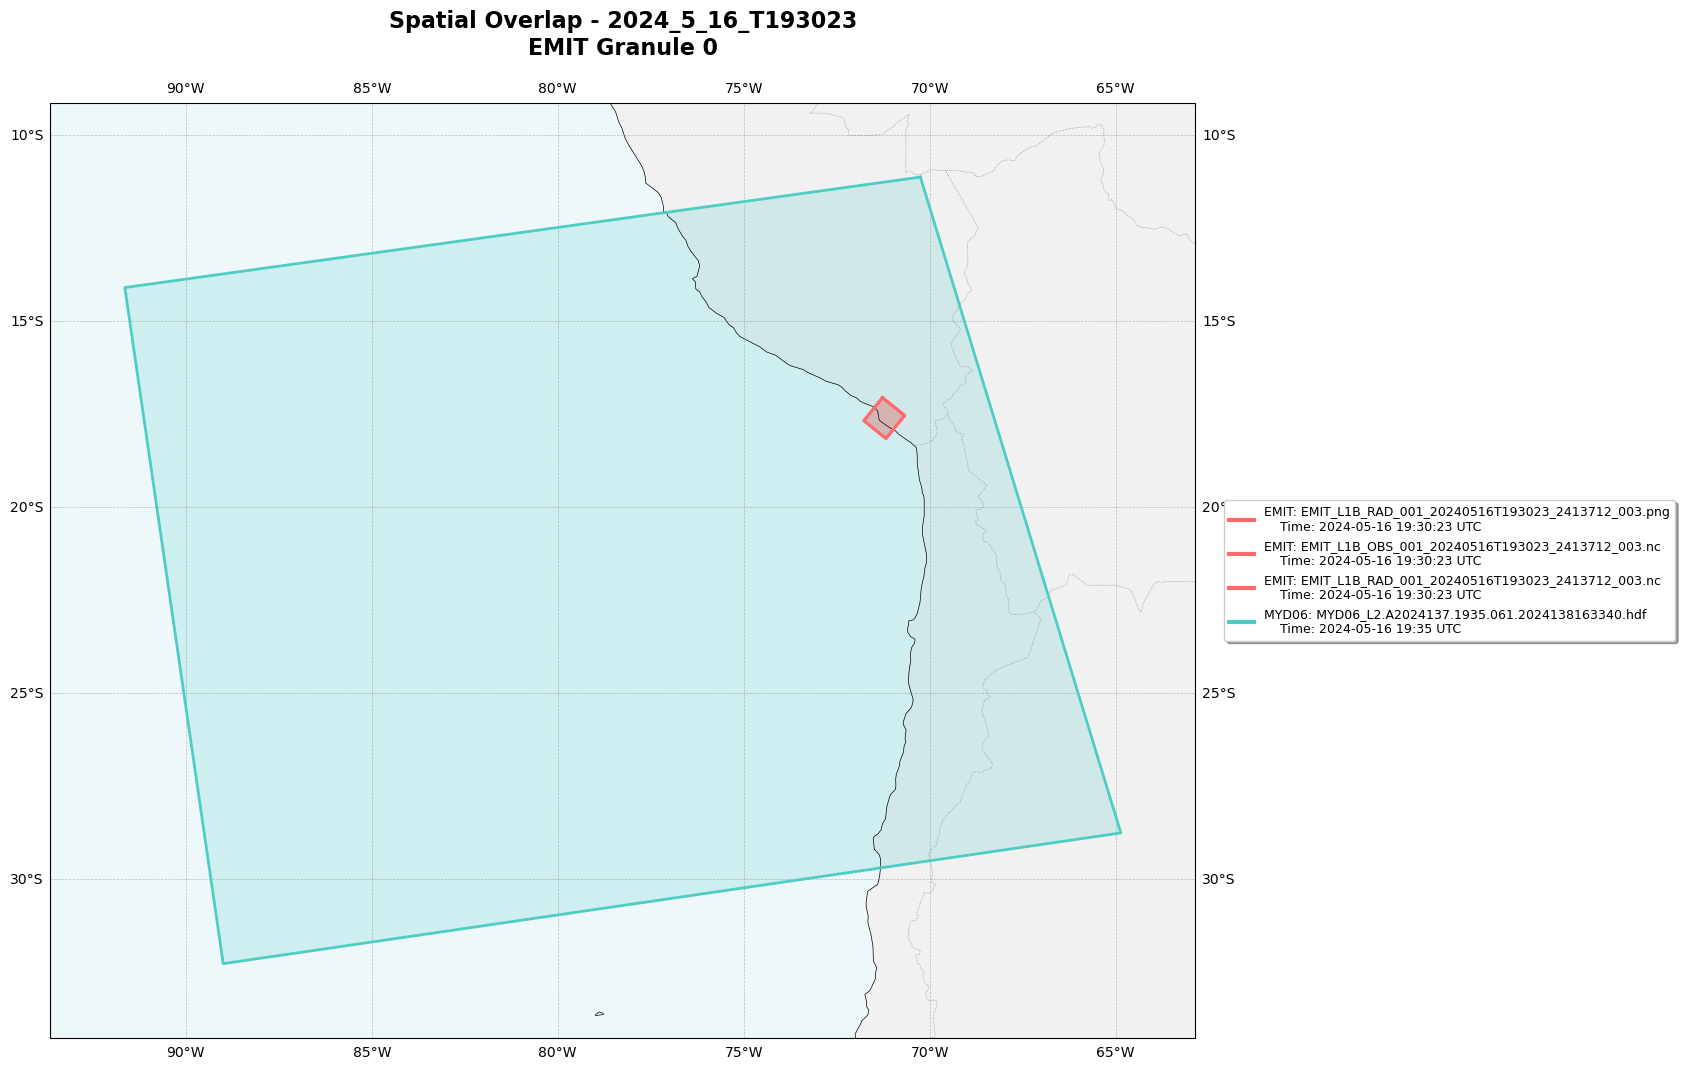

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os

print("Generating spatial overlap visualizations...\n")

# Define color scheme for different products
product_colors = {
    'EMIT': '#FF6B6B',      # Red
    'MYD06': '#4ECDC4',     # Teal
    'MYD021KM': '#45B7D1',  # Light blue
    'MYD05': '#96CEB4',     # Mint green
    'MYD35': '#FFEAA7',     # Yellow
    'MYD03': '#DFE6E9',     # Light gray
    'AIRS': '#A29BFE',      # Purple
    'AMSR': '#FD79A8',      # Pink
}

def extract_time_from_filename(filename):
    """Extract time information from various satellite filename formats."""
    import re
    
    # EMIT format: EMIT_L1B_RAD_001_20240516T193023_2413712_003.nc
    emit_match = re.search(r'(\d{8})T(\d{6})', filename)
    if emit_match:
        date_str = emit_match.group(1)
        time_str = emit_match.group(2)
        return f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]} {time_str[:2]}:{time_str[2:4]}:{time_str[4:6]} UTC"
    
    # MODIS format: MYD06_L2.A2024137.1935.061.2024138163340.hdf
    modis_match = re.search(r'A(\d{7})\.(\d{4})', filename)
    if modis_match:
        year_doy = modis_match.group(1)
        hhmm = modis_match.group(2)
        year = int(year_doy[:4])
        doy = int(year_doy[4:])
        date = dt.datetime(year, 1, 1) + dt.timedelta(days=doy-1)
        return f"{date.strftime('%Y-%m-%d')} {hhmm[:2]}:{hhmm[2:4]} UTC"
    
    # AIRS format: AIRS.2024.05.16.195.L2.RetStd_IR.v7.0.9.3.G25248154654.hdf
    airs_match = re.search(r'AIRS\.(\d{4})\.(\d{2})\.(\d{2})\.(\d{3})', filename)
    if airs_match:
        year, month, day, granule = airs_match.groups()
        # AIRS granule number: 240 granules per day, so granule/10 ≈ hour
        hour = int(granule) // 10
        minute = (int(granule) % 10) * 6
        return f"{year}-{month}-{day} ~{hour:02d}:{minute:02d} UTC"
    
    # AMSR-E format: AMSR_U2_L2_Ocean_V01_202405161913_A.he5
    amsr_match = re.search(r'(\d{12})', filename)
    if amsr_match:
        datetime_str = amsr_match.group(1)
        return f"{datetime_str[:4]}-{datetime_str[4:6]}-{datetime_str[6:8]} {datetime_str[8:10]}:{datetime_str[10:12]} UTC"
    
    return "Unknown time"

def get_product_type(filename):
    """Determine product type from filename."""
    if 'EMIT' in filename:
        return 'EMIT'
    elif 'MYD06' in filename:
        return 'MYD06'
    elif 'MYD021KM' in filename:
        return 'MYD021KM'
    elif 'MYD05' in filename:
        return 'MYD05'
    elif 'MYD35' in filename:
        return 'MYD35'
    elif 'MYD03' in filename:
        return 'MYD03'
    elif 'AIRS' in filename:
        return 'AIRS'
    elif 'AMSR' in filename:
        return 'AMSR'
    else:
        return 'Unknown'

# Function to retrieve polygon from CMR for a given URL
def get_polygon_from_cmr(url, concept_ids_dict):
    """Retrieve polygon geometry from CMR for a specific granule URL."""
    
    # Extract filename from URL
    filename = url.split('/')[-1]
    
    # Determine which concept ID to use based on product type
    product_type = get_product_type(filename)
    
    # Map product types to concept ID keys
    concept_key_map = {
        'EMIT': 'EMIT_L1B',
        'MYD06': 'MYD06_L2',
        'MYD021KM': 'MYD021KM',
        'MYD05': 'MYD05_L2',
        'MYD35': 'MYD35_L2',
        'MYD03': 'MYD03',
        'AIRS': 'AIRS2RET',
        'AMSR': 'AU_Ocean'
    }
    
    concept_key = concept_key_map.get(product_type)
    if not concept_key or concept_key not in concept_ids_dict:
        return None
    
    concept_id = concept_ids_dict[concept_key]
    
    # Search CMR for this specific granule
    try:
        # Use the granule name (without extension) to search
        granule_name = filename.rsplit('.', 1)[0]  # Remove file extension
        
        cmr_param = {
            'collection_concept_id': concept_id,
            'readable_granule_name': granule_name,
            'page_size': 1
        }
        
        response = requests.get(cmrurl + 'granules.json', params=cmr_param)
        granules = response.json()['feed']['entry']
        
        if granules:
            g = granules[0]
            if 'polygons' in g:
                polygons = g['polygons']
                multipolygons = []
                for poly in polygons:
                    i = iter(poly[0].split(" "))
                    ltln = list(map(" ".join, zip(i, i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                return MultiPolygon(multipolygons)
    except Exception as e:
        print(f"    Warning: Could not retrieve polygon for {filename}: {e}")
    
    return None

# Generate figures for each pair
for pair_idx, pair_info in pair_url_mapping.items():
    pair_folder = pair_info['folder']
    pair_urls = pair_info['urls']
    folder_name = pair_info['folder_name']
    
    print(f"Generating figure for pair {pair_idx} ({folder_name})...")
    
    # Organize URLs by product type
    product_data = {}
    
    for url in pair_urls:
        filename = url.split('/')[-1]
        product = get_product_type(filename)
        time_str = extract_time_from_filename(filename)
        
        if product not in product_data:
            product_data[product] = []
        
        product_data[product].append({
            'filename': filename,
            'time': time_str,
            'url': url,
            'polygon': None  # Will fill in next
        })
    
    # Get polygons from stored data or CMR
    pair_data = coincident_pairs[pair_idx]
    
    # EMIT polygon (from stored data)
    emit_idx = pair_data['emit_idx']
    emit_poly = granule_arr[emit_idx][-1]
    
    if 'EMIT' in product_data:
        for item in product_data['EMIT']:
            item['polygon'] = emit_poly
    
    # Aqua MYD06 polygon (from stored data)
    aqua_poly = pair_data['aqua_poly']
    
    if 'MYD06' in product_data:
        for item in product_data['MYD06']:
            item['polygon'] = aqua_poly
    
    # For other products, retrieve from CMR
    print("  Retrieving polygons from CMR...")
    for product in product_data:
        if product not in ['EMIT', 'MYD06']:
            for item in product_data[product]:
                item['polygon'] = get_polygon_from_cmr(item['url'], concept_ids)
    
    # Calculate map bounds
    all_bounds = []
    for product in product_data:
        for item in product_data[product]:
            if item['polygon']:
                bounds = item['polygon'].bounds
                all_bounds.append(bounds)
    
    if not all_bounds:
        print(f"  Warning: No valid polygons found for pair {pair_idx}")
        continue
    
    # Calculate extent with some padding
    min_lon = min(b[0] for b in all_bounds) - 2
    min_lat = min(b[1] for b in all_bounds) - 2
    max_lon = max(b[2] for b in all_bounds) + 2
    max_lat = max(b[3] for b in all_bounds) + 2
    
    # Create figure
    fig = plt.figure(figsize=(16, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Set extent
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    
    # Add features
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='none', alpha=0.3)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', edgecolor='none', alpha=0.2)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='gray', linestyle=':')
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    
    # Plot each product's footprints
    legend_items = []
    
    for product in sorted(product_data.keys()):
        color = product_colors.get(product, '#95A5A6')
        
        for idx, item in enumerate(product_data[product]):
            if item['polygon']:
                # Plot polygon
                if isinstance(item['polygon'], MultiPolygon):
                    for poly in item['polygon'].geoms:
                        x, y = poly.exterior.xy
                        ax.plot(x, y, color=color, linewidth=2, transform=ccrs.PlateCarree())
                        ax.fill(x, y, color=color, alpha=0.2, transform=ccrs.PlateCarree())
                else:
                    x, y = item['polygon'].exterior.xy
                    ax.plot(x, y, color=color, linewidth=2, transform=ccrs.PlateCarree())
                    ax.fill(x, y, color=color, alpha=0.2, transform=ccrs.PlateCarree())
                
                # Add to legend
                label = f"{product}: {item['filename']}\n    Time: {item['time']}"
                legend_items.append(Line2D([0], [0], color=color, linewidth=3, label=label))
    
    # Add title
    ax.set_title(f"Spatial Overlap - {folder_name}\nEMIT Granule {pair_data['emit_idx']}", 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Add legend (outside plot area)
    ax.legend(handles=legend_items, loc='center left', bbox_to_anchor=(1.02, 0.5), 
              fontsize=9, frameon=True, fancybox=True, shadow=True)
    
    # Save figure as JPG
    output_path = os.path.join(pair_folder, 'spatial_overlap_map.jpg')
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight', format='jpg', quality=95)
    plt.close()
    
    print(f"  ✓ Saved: {output_path}\n")

print(f"{'='*70}")
print(f"All spatial overlap figures generated!")
print(f"Figures saved in each pair's folder as 'spatial_overlap_map.jpg'")
print(f"{'='*70}")


### Selection Tips:

**To download specific pairs:**
```python
pairs_to_download = [0, 2, 5]  # Download pairs at indices 0, 2, and 5
```

**To download all pairs:**
```python
pairs_to_download = list(range(len(coincident_pairs)))
```

**To download a range:**
```python
pairs_to_download = list(range(3, 8))  # Pairs 3 through 7
```

**Important:** You need a NASA Earthdata Login and a `.netrc` file configured with your credentials. See the setup instructions at the beginning of the notebook.


---

## Troubleshooting

If you encounter download issues:

1. **Verify NASA Earthdata credentials**: 
   - Make sure you have a `.netrc` file in your home directory with your NASA credentials
   - Set permissions: `chmod 600 ~/.netrc`
   - File format should be:
     ```
     machine urs.earthdata.nasa.gov
     login your_username
     password your_password
     ```

2. **Check wget is installed**:
   - `wget` should be available on macOS by default
   - Test with: `wget --version`

3. **Manual download alternative**:
   - The URLs are saved to `urls_to_download.txt` 
   - You can manually download with: `wget -P /Users/anbu8374/Downloads/coincident_data/ -i /Users/anbu8374/Downloads/coincident_data/urls_to_download.txt`


---

## Contact Info:  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  
Date last modified: 01-20-2023  

¹Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I. 

In [ ]:
print(png_url)

NameError: name 'png_url' is not defined